In [1]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

In [2]:
try:
    df_bos = pd.read_csv('data/mlb18/BOS.txt')
except:
    df_bos = pd.read_csv(pm.get_data('data/mlb18/BOS.txt'))

In [3]:
df_bos.fillna(0, inplace=True)
df_bos

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,...,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak,Orig. Scheduled
0,1,Thursday Mar 29,boxscore,BOS,@,TBR,L,4,6,0.0,...,4,1.0,Pruitt,Smith,Colome,3:00,D,31042,-,0.0
1,2,Friday Mar 30,boxscore,BOS,@,TBR,W,1,0,0.0,...,3,1.0,Price,Roe,Kimbrel,2:46,N,19203,+,0.0
2,3,Saturday Mar 31,boxscore,BOS,@,TBR,W,3,2,0.0,...,1,Tied,Porcello,Kittredge,Kimbrel,3:21,N,17838,++,0.0
3,4,Sunday Apr 1,boxscore,BOS,@,TBR,W,2,1,0.0,...,1,up 1.0,Velazquez,Alvarado,Kelly,3:24,D,14256,+++,0.0
4,5,Monday Apr 2,boxscore,BOS,@,MIA,W,7,3,0.0,...,1,up 1.0,Johnson,Richards,0,3:09,N,11113,++++,0.0
5,6,Tuesday Apr 3,boxscore,BOS,@,MIA,W,4,2,13.0,...,1,up 1.0,Hembree,Guerrero,0,4:27,N,14953,+++++,0.0
6,7,Thursday Apr 5,boxscore,BOS,0,TBR,W-wo,3,2,12.0,...,1,up 2.0,Poyner,Kittredge,0,3:55,D,36134,++++++,0.0
7,8,Saturday Apr 7,boxscore,BOS,0,TBR,W,10,3,0.0,...,1,up 2.5,Porcello,Faria,0,2:48,D,31821,+++++++,0.0
8,9,Sunday Apr 8,boxscore,BOS,0,TBR,W,8,7,0.0,...,1,up 2.5,Smith,Colome,Kimbrel,3:50,D,31979,++++++++,0.0
9,10,Tuesday Apr 10,boxscore,BOS,0,NYY,W,14,1,0.0,...,1,up 2.0,Sale,Severino,0,3:11,N,32357,+++++++++,0.0


In [4]:
df_bos['Home Team'] = np.where(df_bos.iloc[:,4] == '@', df_bos['Opp'], df_bos['Tm'])
df_bos['Away Team'] = np.where(df_bos.iloc[:,4] == '@', df_bos['Tm'], df_bos['Opp'])
df_bos['Home Team Runs'] = np.where(df_bos.iloc[:,4] == '@', df_bos['RA'], df_bos['R'])
df_bos['Away Team Runs'] = np.where(df_bos.iloc[:,4] == '@', df_bos['R'], df_bos['RA'])
df_bos['game'], df_bos['difference'] = np.where(df_bos.iloc[:,4] == '@', df_bos['Tm'] + ' - ' + df_bos['Opp'], df_bos['Opp'] + ' - ' + df_bos['Tm']), np.where(df_bos.iloc[:,4] == '@', df_bos['R'] - df_bos['RA'], df_bos['RA'] - df_bos['R'])
df_bos['games'] = list(zip(df_bos['game'], np.where(df_bos.iloc[:,4] == '@', df_bos['R'], df_bos['RA']), np.where(df_bos.iloc[:,4] == '@', df_bos['RA'], df_bos['R']), df_bos['difference']))

In [5]:
[game for game in list(zip(df_bos['game'], df_bos['Away Team Runs'], df_bos['Home Team Runs'], df_bos['difference'])) if "NYY" in game[0]]

[('NYY - BOS', 1, 14, -13),
 ('NYY - BOS', 10, 7, 3),
 ('NYY - BOS', 3, 6, -3),
 ('BOS - NYY', 2, 3, -1),
 ('BOS - NYY', 6, 9, -3),
 ('BOS - NYY', 5, 4, 1),
 ('BOS - NYY', 1, 8, -7),
 ('BOS - NYY', 11, 0, 11),
 ('BOS - NYY', 1, 11, -10),
 ('NYY - BOS', 7, 15, -8),
 ('NYY - BOS', 1, 4, -3),
 ('NYY - BOS', 1, 4, -3),
 ('NYY - BOS', 4, 5, -1),
 ('BOS - NYY', 2, 3, -1),
 ('BOS - NYY', 1, 10, -9),
 ('BOS - NYY', 11, 6, 5),
 ('NYY - BOS', 11, 6, 5),
 ('NYY - BOS', 8, 5, 3),
 ('NYY - BOS', 2, 10, -8)]

In [6]:
df_bos['Home'] = np.where(df_bos.iloc[:,4] == '@', 0, 1)
df_bos['Win'] = df_bos.R - df_bos.RA
nyy = df_bos[df_bos['Opp']=='NYY'][['Home','R','RA','Win']].reset_index()
nyy['index'] = nyy.index + 1
nyy

,index,Home,R,RA,Win
0,1,1,14,1,13
1,2,1,7,10,-3
2,3,1,6,3,3
3,4,0,2,3,-1
4,5,0,6,9,-3
5,6,0,5,4,1
6,7,0,1,8,-7
7,8,0,11,0,11
8,9,0,1,11,-10
9,10,1,15,7,8


There are 19 games between BOS and NYY. In order to find the best Lineups of BOS against NYY. Input BOS players info and all 19 games data.

In [7]:
roster = pd.read_csv('data/Roster.csv')
roster = pd.DataFrame(roster.Name)
roster['No'] = roster.index + 1
roster

,Name,No
0,Matt Barnes,1
1,Jalen Beeks,2
2,Andrew Benintendi,3
3,Mookie Betts,4
4,Xander Bogaerts,5
5,Jackie Bradley Jr.,6
6,Ryan Brasier,7
7,Dan Butler,8
8,William Cuevas,9
9,Rafael Devers,10


In [8]:
B1 = pd.read_csv('data/BvN/1B.csv')
B1 = pd.merge(B1, roster, left_on='Name', right_on='Name', how='left')
B1.No.fillna(0, inplace=True)
B1.No = B1.No.astype(int)
B1['Game'] = 1
B1

,Name,Batting,AB,R,H,RBI,BB,SO,PA,BA,...,WPA,aLI,WPA+,WPA-,RE24,PO,A,Details,No,Game
0,Mookie Betts,RF,4,5,4,4,1,0,5,0.432,...,0.106,0.46,0.106,0.000,5.0,1.0,0.0,"HR,2·2B",4,1
1,Andrew Benintendi,LF,3,2,2,2,2,0,5,0.206,...,0.216,0.70,0.216,0.000,3.4,3.0,0.0,"3B,2B",3,1
2,Hanley Ramirez,1B,2,1,2,3,1,0,4,0.359,...,0.165,0.74,0.165,0.000,2.7,2.0,0.0,"SB,SF",31,1
3,Blake Swihart,1B,1,0,0,0,0,1,1,0.167,...,0.000,0.00,0.000,0.000,-0.2,2.0,1.0,NaN,37,1
4,J.D. Martinez,DH,5,1,1,2,0,2,5,0.222,...,-0.044,0.49,0.024,-0.068,0.3,NaN,NaN,2B,21,1
5,Rafael Devers,3B,3,0,0,1,1,2,5,0.294,...,0.004,0.45,0.026,-0.022,-0.4,1.0,1.0,SF,10,1
6,Eduardo Nunez,2B,3,1,0,0,1,0,4,0.243,...,-0.074,0.64,0.000,-0.075,-1.1,2.0,0.0,NaN,23,1
7,Tzu-Wei Lin,SS,1,0,0,0,0,1,1,0.000,...,0.000,0.00,0.000,0.000,-0.2,1.0,2.0,NaN,20,1
8,Jackie Bradley Jr.,CF,4,1,1,0,0,1,5,0.133,...,-0.064,0.55,0.004,-0.068,-0.7,2.0,0.0,HBP,6,1
9,Christian Vazquez,C,5,2,1,0,0,1,5,0.258,...,0.023,0.25,0.034,-0.011,0.9,10.0,2.0,NaN,40,1


In [9]:
P1 = pd.read_csv('data/BvN/1P.csv')
P1 = pd.merge(P1, roster, left_on='Name', right_on='Name', how='left')
P1.No.fillna(0, inplace=True)
P1.No = P1.No.astype(int)
P1['Game'] = 1
P1

,Name,Pitching,IP,H,R,ER,BB,SO,HR,ERA,...,LD,Unk,GSc,IR,IS,WPA,aLI,RE24,No,Game
0,Chris Sale,W (1-0),6,8,1,1,0,8,1,1.06,...,4,0,60.0,NaN,NaN,0.206,0.79,2.2,34,1
1,Joe Kelly,NaN,1,1,0,0,0,0,0,8.31,...,0,0,NaN,0.0,0.0,0.000,0.01,0.5,16,1
2,Brian Johnson,NaN,2,1,0,0,1,2,0,3.24,...,1,0,NaN,0.0,0.0,0.000,0.00,1.1,15,1
3,Team Totals,NaN,9,10,1,1,1,10,1,1.00,...,5,0,60.0,0.0,0.0,0.206,0.55,3.8,0,1


In [10]:
B1 = pd.read_csv('data/BvN/1B.csv')
B1['Game'] = 1
B2 = pd.read_csv('data/BvN/2B.csv')
B2['Game'] = 2
B3 = pd.read_csv('data/BvN/3B.csv')
B3['Game'] = 3
B4 = pd.read_csv('data/BvN/4B.csv')
B4['Game'] = 4
B5 = pd.read_csv('data/BvN/5B.csv')
B5['Game'] = 5
B6 = pd.read_csv('data/BvN/6B.csv')
B6['Game'] = 6
B7 = pd.read_csv('data/BvN/7B.csv')
B7['Game'] = 7
B8 = pd.read_csv('data/BvN/8B.csv')
B8['Game'] = 8
B9 = pd.read_csv('data/BvN/9B.csv')
B9['Game'] = 9
B10 = pd.read_csv('data/BvN/10B.csv')
B10['Game'] = 10
B11 = pd.read_csv('data/BvN/11B.csv')
B11['Game'] = 11
B12 = pd.read_csv('data/BvN/12B.csv')
B12['Game'] = 12
B13 = pd.read_csv('data/BvN/13B.csv')
B13['Game'] = 13
B14 = pd.read_csv('data/BvN/14B.csv')
B14['Game'] = 14
B15 = pd.read_csv('data/BvN/15B.csv')
B15['Game'] = 15
B16 = pd.read_csv('data/BvN/16B.csv')
B16['Game'] = 16
B17 = pd.read_csv('data/BvN/17B.csv')
B17['Game'] = 17
B18 = pd.read_csv('data/BvN/18B.csv')
B18['Game'] = 18
B19 = pd.read_csv('data/BvN/19B.csv')
B19['Game'] = 19

In [11]:
P1 = pd.read_csv('data/BvN/1P.csv')
P1['Game'] = 1
P2 = pd.read_csv('data/BvN/2P.csv')
P2['Game'] = 2
P3 = pd.read_csv('data/BvN/3P.csv')
P3['Game'] = 3
P4 = pd.read_csv('data/BvN/4P.csv')
P4['Game'] = 4
P5 = pd.read_csv('data/BvN/5P.csv')
P5['Game'] = 5
P6 = pd.read_csv('data/BvN/6P.csv')
P6['Game'] = 6
P7 = pd.read_csv('data/BvN/7P.csv')
P7['Game'] = 7
P8 = pd.read_csv('data/BvN/8P.csv')
P8['Game'] = 8
P9 = pd.read_csv('data/BvN/9P.csv')
P9['Game'] = 9
P10 = pd.read_csv('data/BvN/10P.csv')
P10['Game'] = 10
P11 = pd.read_csv('data/BvN/11P.csv')
P11['Game'] = 11
P12 = pd.read_csv('data/BvN/12P.csv')
P12['Game'] = 12
P13 = pd.read_csv('data/BvN/13P.csv')
P13['Game'] = 13
P14 = pd.read_csv('data/BvN/14P.csv')
P14['Game'] = 14
P15 = pd.read_csv('data/BvN/15P.csv')
P15['Game'] = 15
P16 = pd.read_csv('data/BvN/16P.csv')
P16['Game'] = 16
P17 = pd.read_csv('data/BvN/17P.csv')
P17['Game'] = 17
P18 = pd.read_csv('data/BvN/18P.csv')
P18['Game'] = 18
P19 = pd.read_csv('data/BvN/19P.csv')
P19['Game'] = 19

In [12]:
B = pd.concat([B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19],ignore_index=True)
B = pd.merge(B, roster, left_on='Name', right_on='Name', how='left')
B.No.fillna(0, inplace=True)
B.No = B.No.astype(int)
BR = B.groupby('No').mean().reset_index()
BR['BNo'] = BR.index - 1
BR

,No,AB,R,H,RBI,BB,SO,PA,BA,OBP,...,Str,WPA,aLI,WPA+,WPA-,RE24,PO,A,Game,BNo
0,0,35.368421,6.105263,9.684211,5.736842,3.684211,9.473684,39.736842,0.266947,0.335842,...,101.473684,0.120789,0.744737,0.629368,-0.508368,1.463158,26.210526,7.578947,10.000000,-1
1,3,3.941176,0.647059,1.411765,0.705882,0.411765,0.823529,4.352941,0.274118,0.367706,...,11.235294,0.063706,0.877059,0.111882,-0.048235,0.664706,2.058824,0.058824,9.941176,0
2,4,3.823529,1.294118,1.588235,0.882353,0.764706,0.823529,4.647059,0.354882,0.442941,...,11.352941,0.053941,0.741176,0.093176,-0.039353,0.823529,2.000000,0.133333,9.294118,1
3,5,3.692308,0.384615,0.769231,0.307692,0.307692,1.000000,4.076923,0.291154,0.349231,...,10.692308,-0.006462,0.937692,0.075077,-0.081308,-0.292308,1.230769,1.846154,11.153846,2
4,6,3.062500,0.750000,0.750000,0.250000,0.437500,1.000000,3.687500,0.208562,0.295313,...,9.600000,-0.001813,0.630625,0.042625,-0.044313,-0.012500,2.466667,0.066667,10.125000,3
5,10,3.769231,0.384615,0.769231,0.461538,0.153846,1.307692,4.000000,0.250308,0.309769,...,10.076923,-0.019308,0.589231,0.034077,-0.053385,-0.238462,0.538462,1.615385,8.846154,4
6,14,3.200000,0.600000,0.666667,0.400000,0.400000,0.800000,3.600000,0.230533,0.344467,...,9.200000,-0.009867,0.622000,0.038867,-0.048667,0.026667,1.285714,1.214286,10.400000,5
7,18,3.285714,0.714286,0.714286,0.428571,0.714286,0.285714,4.000000,0.243714,0.304429,...,10.000000,-0.013714,0.731429,0.058429,-0.072000,-0.057143,0.714286,1.714286,14.857143,6
8,19,2.583333,0.416667,0.666667,0.416667,0.166667,0.583333,2.750000,0.195167,0.237333,...,7.166667,0.006417,0.618333,0.031417,-0.024917,0.008333,6.800000,0.400000,10.250000,7
9,20,1.000000,0.500000,0.166667,0.000000,0.333333,0.666667,1.333333,0.151333,0.285667,...,4.600000,0.001500,0.068333,0.003167,-0.001667,-0.016667,0.200000,1.000000,12.000000,8


Set new mark for batters

In [13]:
B = pd.merge(B, BR[['No','BNo']], left_on='No', right_on='No')

In [14]:
P = pd.concat([P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19],ignore_index=True)
P = pd.merge(P, roster, left_on='Name', right_on='Name', how='left')
P.No.fillna(0, inplace=True)
P.No = P.No.astype(int)
PR = P.groupby('No').mean().reset_index()
PR['PNo'] = PR.index - 1
PR

,No,IP,H,R,ER,BB,SO,HR,ERA,BF,...,LD,Unk,GSc,IR,IS,WPA,aLI,RE24,Game,PNo
0,0,8.736842,7.894737,5.368421,5.000000,3.526316,8.578947,1.789474,5.266316,37.684211,...,5.789474,0.0,54.473684,1.444444,0.833333,-0.094684,0.736316,-0.705263,10.000000,-1
1,1,0.820000,0.600000,0.800000,0.800000,0.600000,0.800000,0.000000,3.764000,3.800000,...,0.600000,0.0,NaN,0.000000,0.000000,-0.023000,1.356000,-0.140000,9.000000,0
2,7,0.880000,0.600000,0.400000,0.400000,0.400000,0.800000,0.200000,1.640000,4.200000,...,0.600000,0.0,NaN,0.800000,0.600000,-0.074400,0.462000,-0.120000,14.400000,1
3,9,0.700000,3.000000,2.666667,2.666667,0.333333,1.000000,0.333333,5.773333,6.000000,...,1.666667,0.0,NaN,0.000000,0.000000,-0.080000,0.300000,-2.333333,15.333333,2
4,11,5.333333,2.000000,0.333333,0.000000,1.000000,4.333333,0.000000,3.723333,18.666667,...,4.000000,0.0,68.666667,NaN,NaN,0.259000,1.030000,2.533333,14.666667,3
5,12,2.100000,4.000000,2.000000,2.000000,1.000000,0.000000,1.000000,5.050000,11.500000,...,2.000000,0.0,NaN,0.000000,0.000000,-0.013500,0.030000,-0.800000,8.000000,4
6,13,0.575000,1.000000,1.250000,1.000000,0.625000,0.625000,0.250000,4.215000,4.000000,...,0.500000,0.0,NaN,0.750000,0.625000,-0.138125,0.955000,-1.075000,10.500000,5
7,15,2.440000,2.200000,1.400000,1.200000,1.000000,3.600000,0.800000,3.906000,11.000000,...,2.000000,0.0,45.500000,0.666667,0.000000,-0.027800,0.594000,0.060000,7.000000,6
8,16,0.712500,1.000000,0.375000,0.375000,0.500000,0.625000,0.000000,4.822500,4.125000,...,0.625000,0.0,NaN,1.000000,0.625000,-0.022000,0.737500,-0.212500,9.250000,7
9,17,0.866667,0.833333,0.500000,0.500000,0.333333,2.000000,0.166667,1.981667,4.000000,...,0.666667,0.0,NaN,0.500000,0.333333,-0.025000,1.060000,-0.100000,10.166667,8


Set new mark for pitcher

In [15]:
P = pd.merge(P, PR[['No','PNo']], left_on='No', right_on='No')

There are 19 batter and 22 pitcher of BOS who played againest NYY, WPA(Win Probability Added) means the change in probability caused by this batter during the game of each player. Its value is the sum of WPA+(Sum of positive events for this batter) and WPA-(Sum of negative events for this batter).

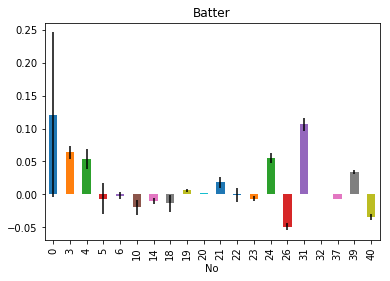

In [16]:
B.groupby('No').mean().WPA.plot(kind='bar', title='Batter', yerr=B.groupby('No').var().WPA);

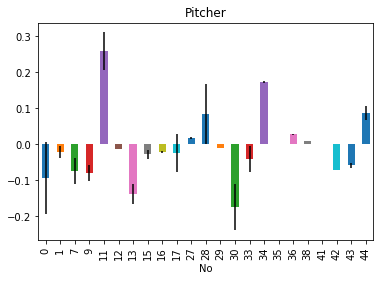

In [17]:
P.groupby('No').mean().WPA.plot(kind='bar', title='Pitcher', yerr=P.groupby('No').var().WPA);

In [18]:
WPA = pd.merge(B[B['No']==0], P[P['No']==0], left_on='Game', right_on='Game', how='left')
WPA['WPA'] = WPA.WPA_x+WPA.WPA_y
WPA = pd.merge(WPA, nyy, left_on='Game', right_on='index')
WPA[['WPA','Win']]

,WPA,Win
0,0.498,13
1,-0.500,-3
2,0.502,3
3,-0.500,-1
4,-0.500,-3
5,0.500,1
6,-0.501,-7
7,0.500,11
8,-0.502,-10
9,0.500,8


A change of +/- 0 would indicate one win added or lost.

Distribution of WPA+:

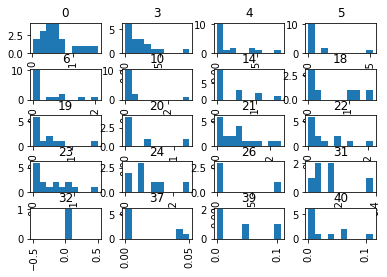

In [19]:
B.hist('WPA+', by='No');

Distribution of WPA-:

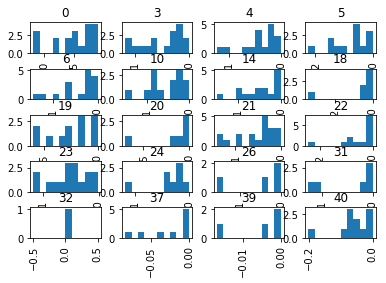

In [20]:
B.hist('WPA-', by='No');

Distribution of pitchers' WPA:

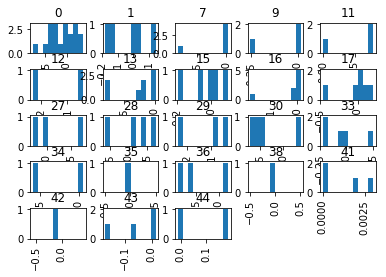

In [21]:
P.hist('WPA', by='No');

Assume batters' WPA+,WPA- are Poisson distribution, pitchers' WPA are Student-T distribution

In [22]:
#delete the data of Team Totals
OB = B[B['No']>0]
OP = P[P['No']>0]

#get batters No
batter = OB.BNo.values

#get pitchers NO 
pitcher = OP.PNo.values

obwpa1 = OB['WPA+'].values
obwpa2 = abs(OB['WPA-'].values)

opwpa = OP.WPA.values

In [23]:
with pm.Model() as bmodel:

    wpa1 = pm.Normal("wpa1", mu=0.05, sd=0.05, shape=19)
    wpa2 = pm.Normal("wpa2", mu=0.04, sd=0.05, shape=19)

    wpa1_theta = tt.exp(wpa1[batter])
    wpa2_theta = tt.exp(wpa2[batter])

    wpa1_points = pm.Poisson('wpa1_points', mu=wpa1_theta, observed=obwpa1)
    wpa2_points = pm.Poisson('wpa2_points', mu=wpa2_theta, observed=obwpa2)
    
    wpap = pm.Deterministic('wpap', wpa1 - wpa2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [wpa2, wpa1]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2135.11draws/s]


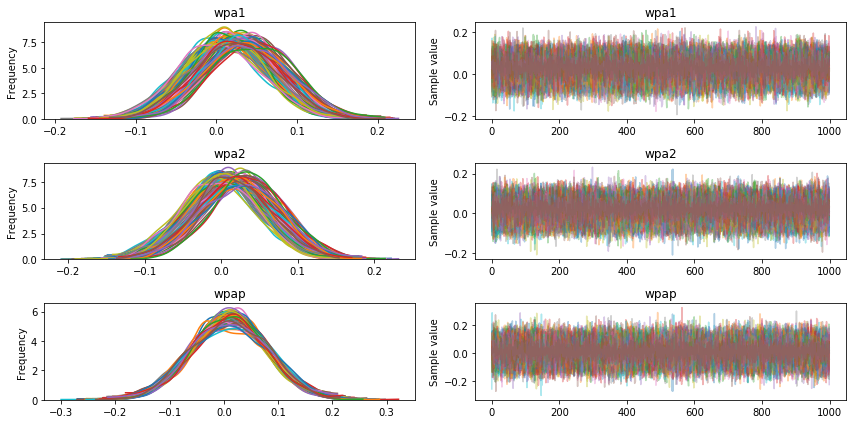

In [24]:
with bmodel:
    btrace = pm.sample(1000, tune=1000)
    pm.traceplot(btrace)

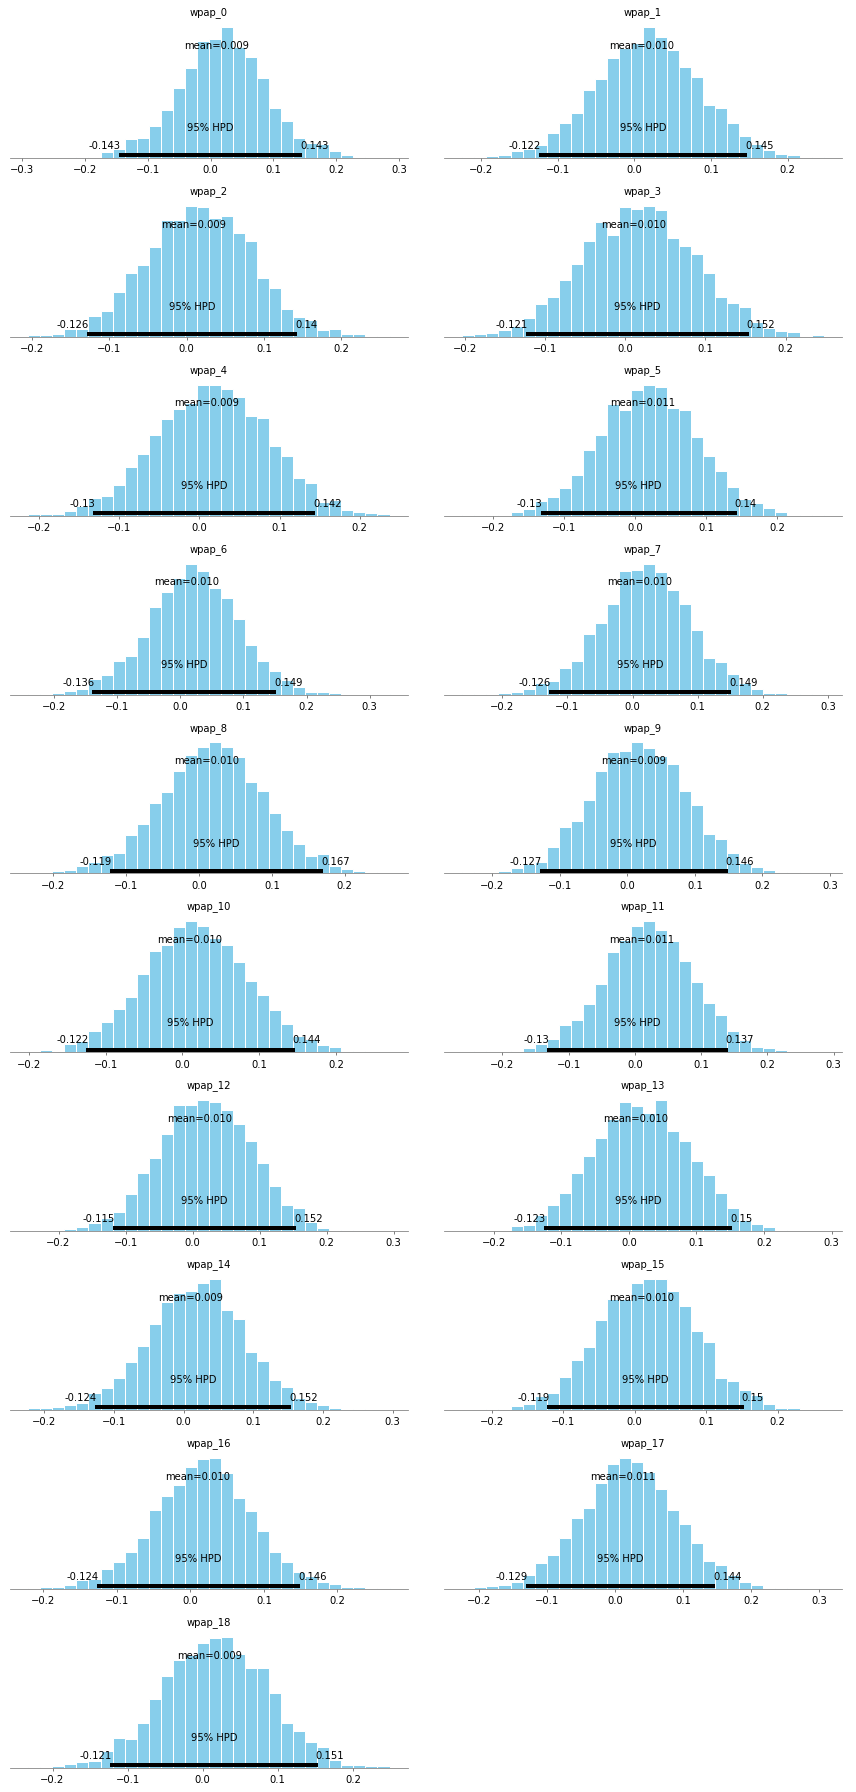

In [25]:
pm.plot_posterior(btrace, varnames=['wpap']);

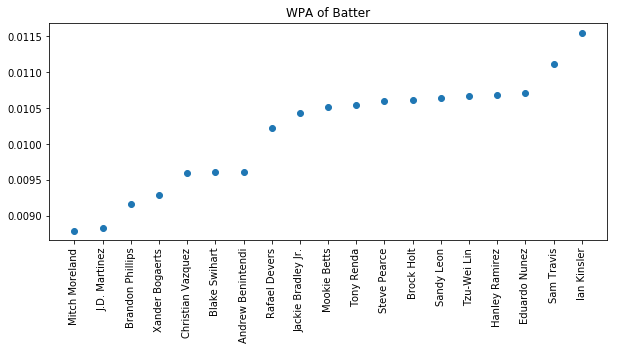

In [26]:
df_wpa1 = pd.DataFrame(pm.stats.quantiles(btrace['wpa1'])[50],columns=['WPA+'])
df_wpa2 = pd.DataFrame(-pm.stats.quantiles(btrace['wpa2'])[50],columns=['WPA-'])
df_wpap = pd.DataFrame(pm.stats.quantiles(btrace['wpap'])[50],columns=['WPA'])
bdf = pd.concat([df_wpa1,df_wpa2,df_wpap],axis=1)
bdf.index.name = 'BNo'
bdf = pd.merge(bdf,BR[['BNo','No']],left_on='BNo',right_on='BNo')
bdf = pd.merge(bdf,roster,left_on='No',right_on='No')
bdf['lower'] = bdf.WPA - bdf['WPA-']
bdf['upper'] = bdf['WPA+'] - bdf.WPA
bdf = bdf.sort_values(by='WPA').reset_index()
bdf['x'] = bdf.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(bdf.x, bdf.WPA,fmt='o')
axs.set_title('WPA of Batter')
_= axs.set_xticks(bdf.x)
_= axs.set_xticklabels(bdf.Name.values, rotation=90)

So last 9 batters who has the biggest WPA will be the best lineups to against NYY

In [27]:
with pm.Model() as pmodel:

    pwpa = pm.Normal("pwpa", mu=-0.005, sd=0.05, shape=22)

    pwpa_theta = tt.exp(pwpa[pitcher])  

    pwpa_points = pm.StudentT('pwpa_points', nu=15,mu=0,sd=pwpa_theta, observed=opwpa)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pwpa]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2554.24draws/s]


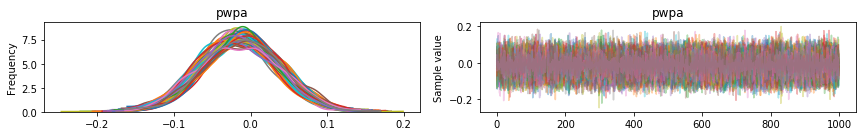

In [28]:
with pmodel:
    ptrace = pm.sample(1000, tune=1000)
    pm.traceplot(ptrace)

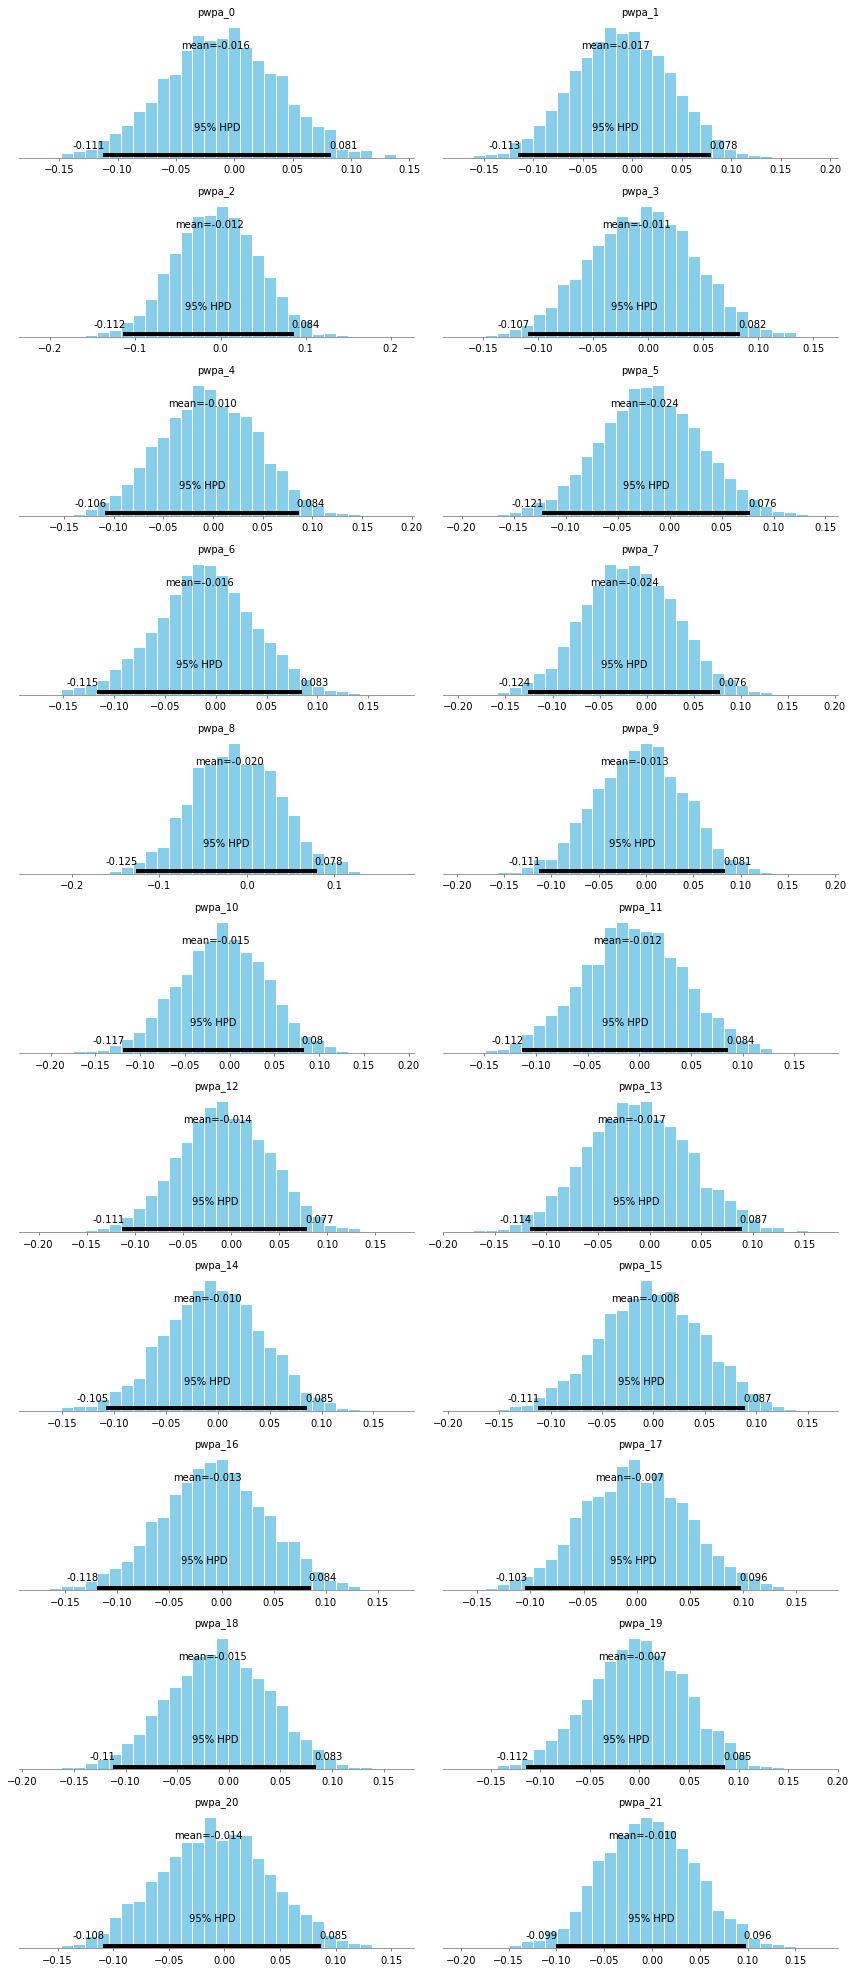

In [29]:
pm.plot_posterior(ptrace, varnames=['pwpa']);

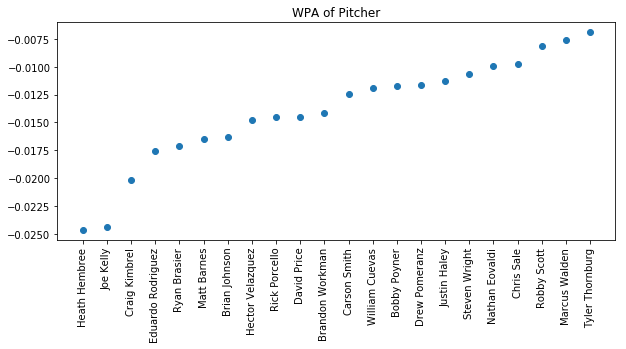

In [30]:
pdf = pd.DataFrame(pm.stats.quantiles(ptrace['pwpa'])[50],columns=['WPA'])
pdf.index.name = 'PNo'
pdf = pd.merge(pdf,PR[['PNo','No']],left_on='PNo',right_on='PNo')
pdf = pd.merge(pdf,roster,left_on='No',right_on='No')
pdf = pdf.sort_values(by='WPA').reset_index()
pdf['x'] = pdf.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(pdf.x, pdf.WPA,fmt='o')
axs.set_title('WPA of Pitcher')
_= axs.set_xticks(pdf.x)
_= axs.set_xticklabels(pdf.Name.values, rotation=90)

The average number of pitchers for each game:

In [31]:
(len(P1)+len(P2)+len(P3)+len(P4)+len(P5)+len(P6)+len(P7)+len(P8)+len(P9)+len(P10)+len(P11)+len(P12)+len(P13)+len(P14)+len(P15)+len(P16)+len(P17)+len(P18)+len(P19)-19)/19.

4.315789473684211

So last 4 pitchers who has the biggest WPA will be the best lineups to against NYY